<a href="https://colab.research.google.com/github/henriqueburis/Potato_Classification_CNN/blob/main/segment_anything_potato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/facebookresearch/segment-anything.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 284 (delta 132), reused 119 (delta 119), pack-reused 83
Receiving objects: 100% (284/284), 18.31 MiB | 8.43 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [ ]:
import os
os.chdir('/content/segment-anything')

In [ ]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-05-23 16:30:19--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.33.39, 13.33.33.102, 13.33.33.42, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.33.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   248MB/s    in 14s     

2023-05-23 16:30:33 (179 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor

In [ ]:
#checkpoint = "sam_vit_h_4b8939.pth"
#checkpoint = "sam_vit_l_0b3195.pth"
#checkpoint = "sam_vit_b_01ec64.pth"

checkpoint = "/content/sam_vit_h_4b8939.pth"

model_type = "vit_h"
#model_type = "vit_l"
#model_type = "vit_b"

print('==> Building model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

sam = sam_model_registry[model_type](checkpoint=checkpoint)
sam.to(device=device)


In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    #print(sorted_anns)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

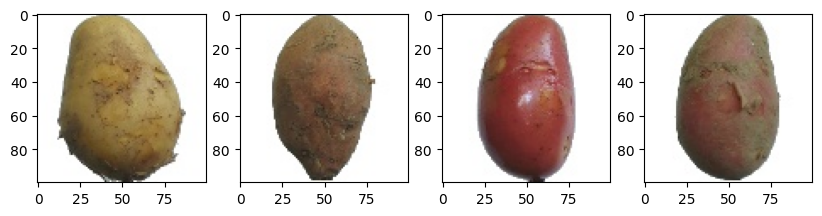

In [127]:
classe_ = ["Potato White","Potato Sweet","Potato Red Washed","Potato Red"]

img1 = cv2.cvtColor(cv2.imread('/content/Potato White.jpg'), cv2.COLOR_BGR2RGB)
img3 =  cv2.cvtColor(cv2.imread('/content/Potato Red Washed.jpg'), cv2.COLOR_BGR2RGB)
img2 =  cv2.cvtColor(cv2.imread('/content/Potato Sweet.jpg'), cv2.COLOR_BGR2RGB) 
img4 =  cv2.cvtColor(cv2.imread('/content/Potato Red.jpg'), cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(10, 5))
axs[0].imshow(img1)
axs[1].imshow(img2)
axs[2].imshow(img3)
axs[3].imshow(img4)
plt.show() 

In [ ]:
img = cv2.imread('/content/example6.jpg')
img =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

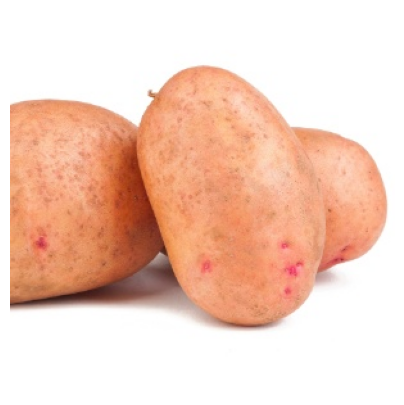

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.axis('off')
plt.show() 

In [ ]:
mask_generator = SamAutomaticMaskGenerator(model=sam,
                points_per_side=32,
                pred_iou_thresh=0.86,
                stability_score_thresh=0.92,
                crop_n_layers=0,  # 1 by default
                crop_n_points_downscale_factor=2,
                min_mask_region_area=100,  # Requires open-cv to run post-processing
                #output_mode='coco_rle',
                )

masks = mask_generator.generate(img)

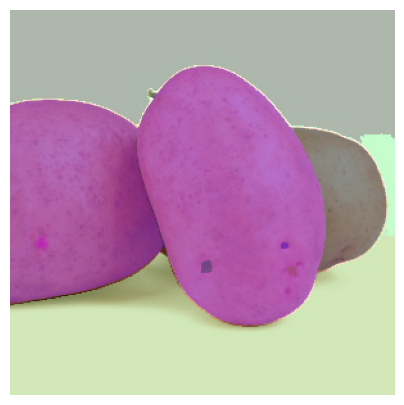

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(img)
show_anns(masks)
plt.axis('off')
plt.show() 

In [ ]:
print(len(masks))

12


In [114]:
import numpy as np
from skimage import measure

threshold = 0.0 # valor de limiar (opcional)
binary_mask = (masks[2]['segmentation'].T > threshold).astype(np.uint8)

labels = measure.label(binary_mask)
#print(labels)

bbox_list = []
for region in measure.regionprops(labels):
    bbox = region.bbox # retorna (min_row, min_col, max_row, max_col)
    bbox_list.append(bbox)
input_box = np.array(bbox_list[0])
print(input_box)


xmin, ymin, xmax, ymax = input_box
roi = img[ymin:ymax, xmin:xmax]


[ 99  44 246 245]


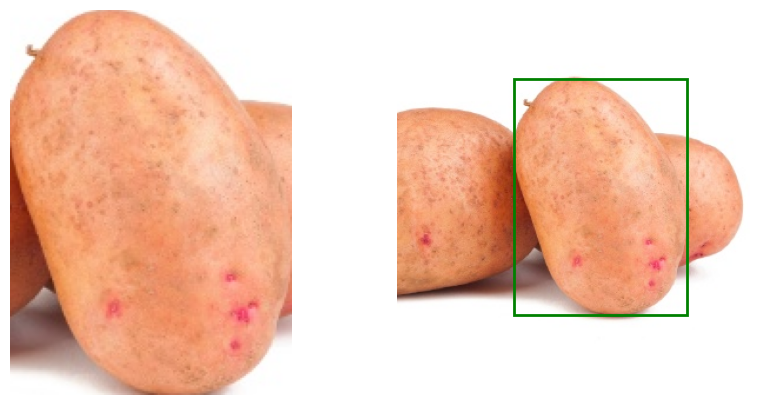

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#axs[0].figure(figsize=(5,5))
axs[0].imshow(roi)
axs[0].axis('off')
#plt.show() 

#axs[1].figure(figsize=(5,5))
axs[1].imshow(img)
show_box(input_box,plt.gca())
axs[1].axis('off')

plt.show() 

In [116]:
import cv2
import torch
import torchvision
import torch.nn as nn
import numpy as np
import imutils
import tensorflow as tf
from torchvision import transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn

In [117]:
print('==> Building model..')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = models.resnet50(weights='ResNet50_Weights.DEFAULT')
modules = list(net.children())[:-1]
modules.append(nn.Flatten())
modules.append(nn.Linear(net.fc.in_features,4))
net = nn.Sequential(*modules)
net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True


==> Building model..


In [118]:
print('==> load model..')
net.load_state_dict(torch.load("/content/28102004model.pt",map_location=device))

==> load model..


<All keys matched successfully>

In [119]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [122]:
tensor_roi = transform(roi)

print(tensor_roi.shape)

outputs = net(tensor_roi.unsqueeze(0)) # predizer a img
_, predicted = outputs.max(1)

print(classe_[predicted.cpu()])

torch.Size([3, 128, 128])
Potato Red Washed
